Kaggle competition - predict housing prices
***
* website: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/tutorialsa
* dataset: 79 variables, target: sale price
* evaluation: RMSE of (log_pred - log_actual)
* comment:
    - regression problem 
    - there are more variables to train data, so we might need to be careful with overfitting. 
    - might use lasso for feature selection, pca for dimension reduction, ridge if we want to include all features in analysis.
    - intuitively, we prefer linear regression with regularization and we'll select models from standard choices.
    - we'll try xgboost,just for reference, since the dataset is small compared to number of features, xgboost is prone to overfitting and not preferred here.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import scipy as sp
import sklearn.preprocessing
plt.style.use('ggplot')
%matplotlib inline
print(sklearn.__version__) # check version as some preprocessing functions are not available in early versions

import warnings
warnings.filterwarnings('ignore')

0.21.2


## info on training data

In [2]:
train_df= pd.read_csv('.\\data\\train.csv')
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
train_df.columns
train_df.shape
train_df.info(verbose=True,null_counts=True)

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

(1460, 81)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Comment
***
from dataframe info summary, some columns such as Alley, PoolQC are missing a lot of data

In [4]:
# identify columns
targetcol = ['SalePrice']
idcol = ['Id']
catcols=[str.strip(x) for x in pd.read_csv('.\\data\\catcols.txt').columns.tolist()]
numcols=[str.strip(x) for x in pd.read_csv('.\\data\\numcols.txt').columns.tolist()] 

In [5]:
','.join(catcols)
','.join(numcols)

'Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,Electrical,ExterCond,ExterQual,Exterior1st,Exterior2nd,Fence,FireplaceQu,Foundation,Functional,GarageCond,GarageFinish,GarageQual,GarageType,Heating,HeatingQC,HouseStyle,KitchenQual,LandContour,LandSlope,LotConfig,LotShape,MSZoning,MasVnrType,MiscFeature,Neighborhood,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities'

'1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,GarageCars,GarageYrBlt,GrLivArea,HalfBath,KitchenAbvGr,LotArea,LotFrontage,LowQualFinSF,MSSubClass,MasVnrArea,MiscVal,MoSold,OpenPorchSF,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold'

## info on target (sales price)

Text(0.5, 1.0, 'plot sales price')

<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'plot log(sales price) vs normal dist')

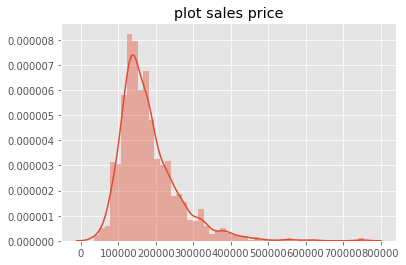

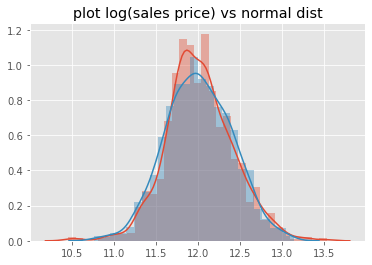

In [6]:
# plot sales prices
sns.distplot(train_df[targetcol]).set_title('plot sales price')
plt.figure()
sns.distplot(np.log(train_df[targetcol])).set_title('plot log(sales price) vs normal dist')
sns.distplot(np.random.normal(np.log(train_df[targetcol]).mean().values[0], np.log(train_df[targetcol]).std().values[0], len(train_df.index)))

In [7]:
# transform log price
train_df[targetcol] = np.log1p(train_df[targetcol])

## analysis on missing values

PoolQC         0.995205
MiscFeature    0.963014
Alley          0.937671
dtype: float64

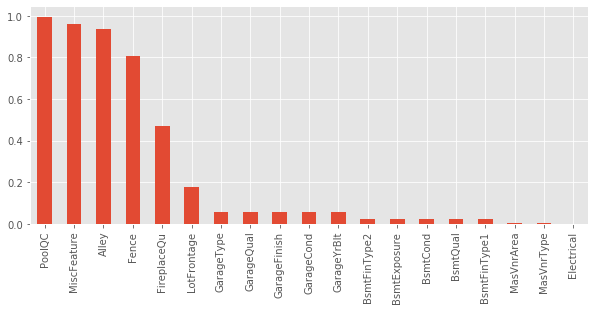

In [8]:
missing = (train_df[catcols+numcols].isnull().astype(int).sum().sort_values(ascending=False))/len(train_df.index)
missing = missing[missing>0]
missing.plot(kind='bar',figsize=(10,4))
missing.head(3)

Comment
***
PoolQC,MiscFeature,Alley have over 90% of data missing. We'll drop these columns.

In [9]:
# set columns to delete
delcols = ['PoolQC','MiscFeature','Alley']
# drop columns in dataframe
train_df.drop(delcols,axis=1,inplace=True)
# update list of categorical columns for usage later
catcols = [x for x in catcols if x not in delcols]
# # double check unique values in categorical columns as we'll fill nan with string 'MISSING'
# for c in missing.index:
#     if c not in delcols:
#         print(c)
#         print(train_df[c].unique())

In [10]:
# treat missing as 'None', num with median
# the usage of Imputer here is for 
from sklearn.impute import SimpleImputer
imp_cat = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value='Missing')
imp_cat.fit(train_df[catcols])
train_df[catcols] = imp_cat.transform(train_df[catcols])
print('check missing val for categoricals:%f'%train_df[catcols].isnull().astype(int).sum().sum())

imp_num = SimpleImputer(missing_values=np.nan, strategy='median')
imp_num.fit(train_df[numcols])
train_df[numcols] = imp_num.transform(train_df[numcols])
print('check missing val for numericals:%f'%train_df[numcols].isnull().astype(int).sum().sum())

SimpleImputer(add_indicator=False, copy=True, fill_value='Missing',
              missing_values=nan, strategy='constant', verbose=0)

check missing val for categoricals:0.000000


SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

check missing val for numericals:0.000000


Check outliers

Text(0.5, 1.0, 'check outliers')

Text(0.5, 0, 'GrLivArea')

Text(0, 0.5, 'SalePrice')

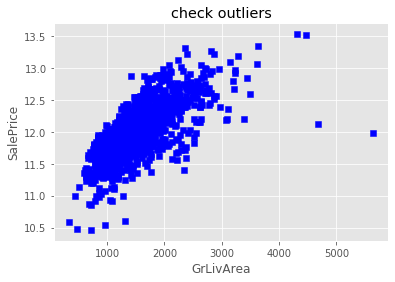

In [11]:
plt.scatter(train_df.GrLivArea, train_df.SalePrice, c = "blue", marker = "s")
plt.title("check outliers")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

## info on categorical columns
* we plot categories versus log(SalePrice) for each column 

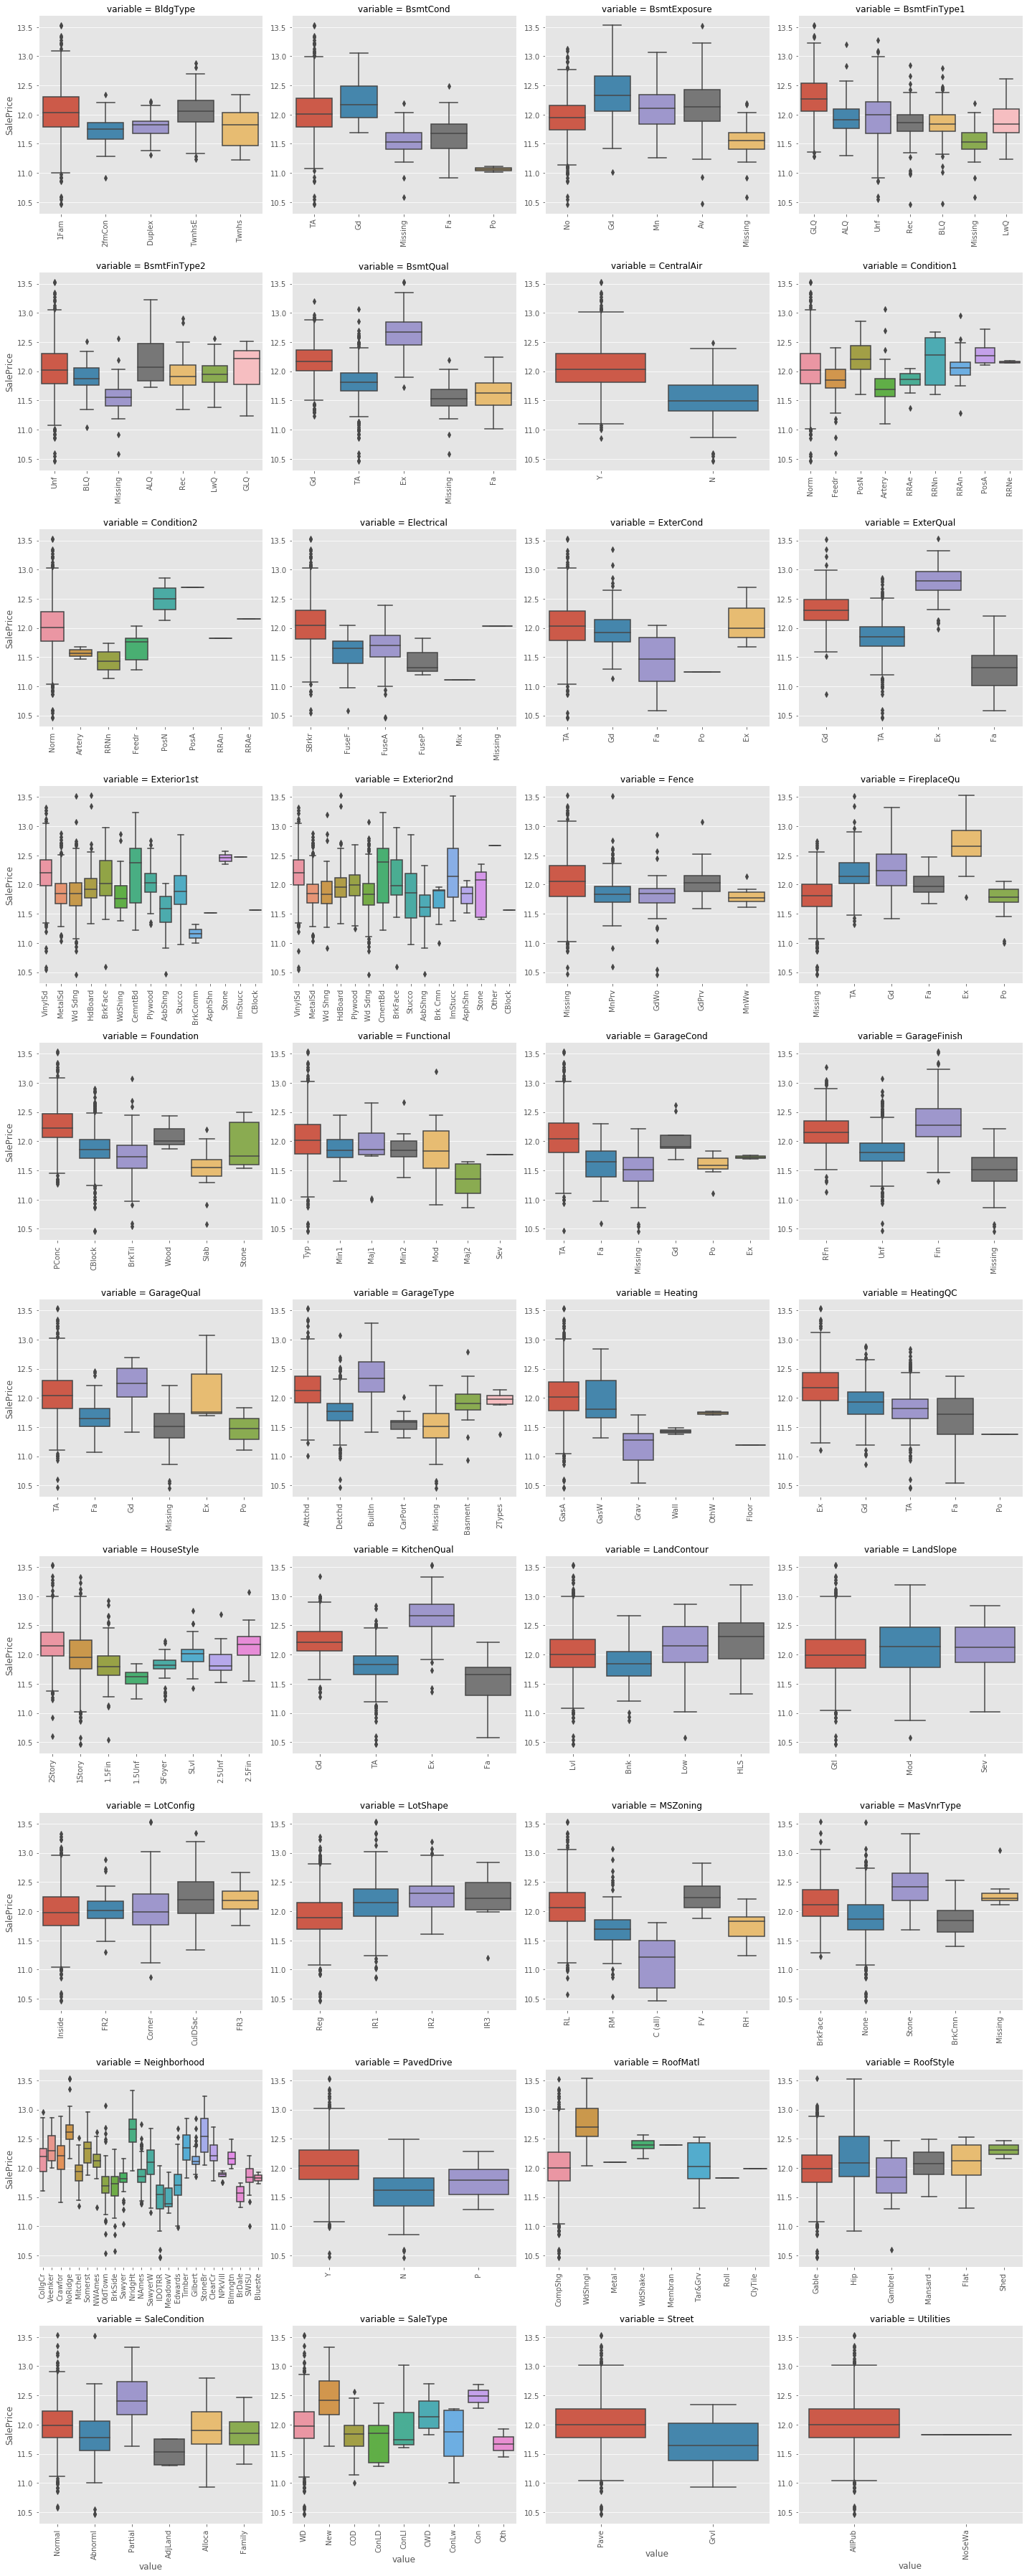

In [12]:
def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
    
f = pd.melt(train_df, id_vars=['SalePrice'], value_vars=catcols)
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "SalePrice")

### info on numerical columns
* we plot distribution of each column

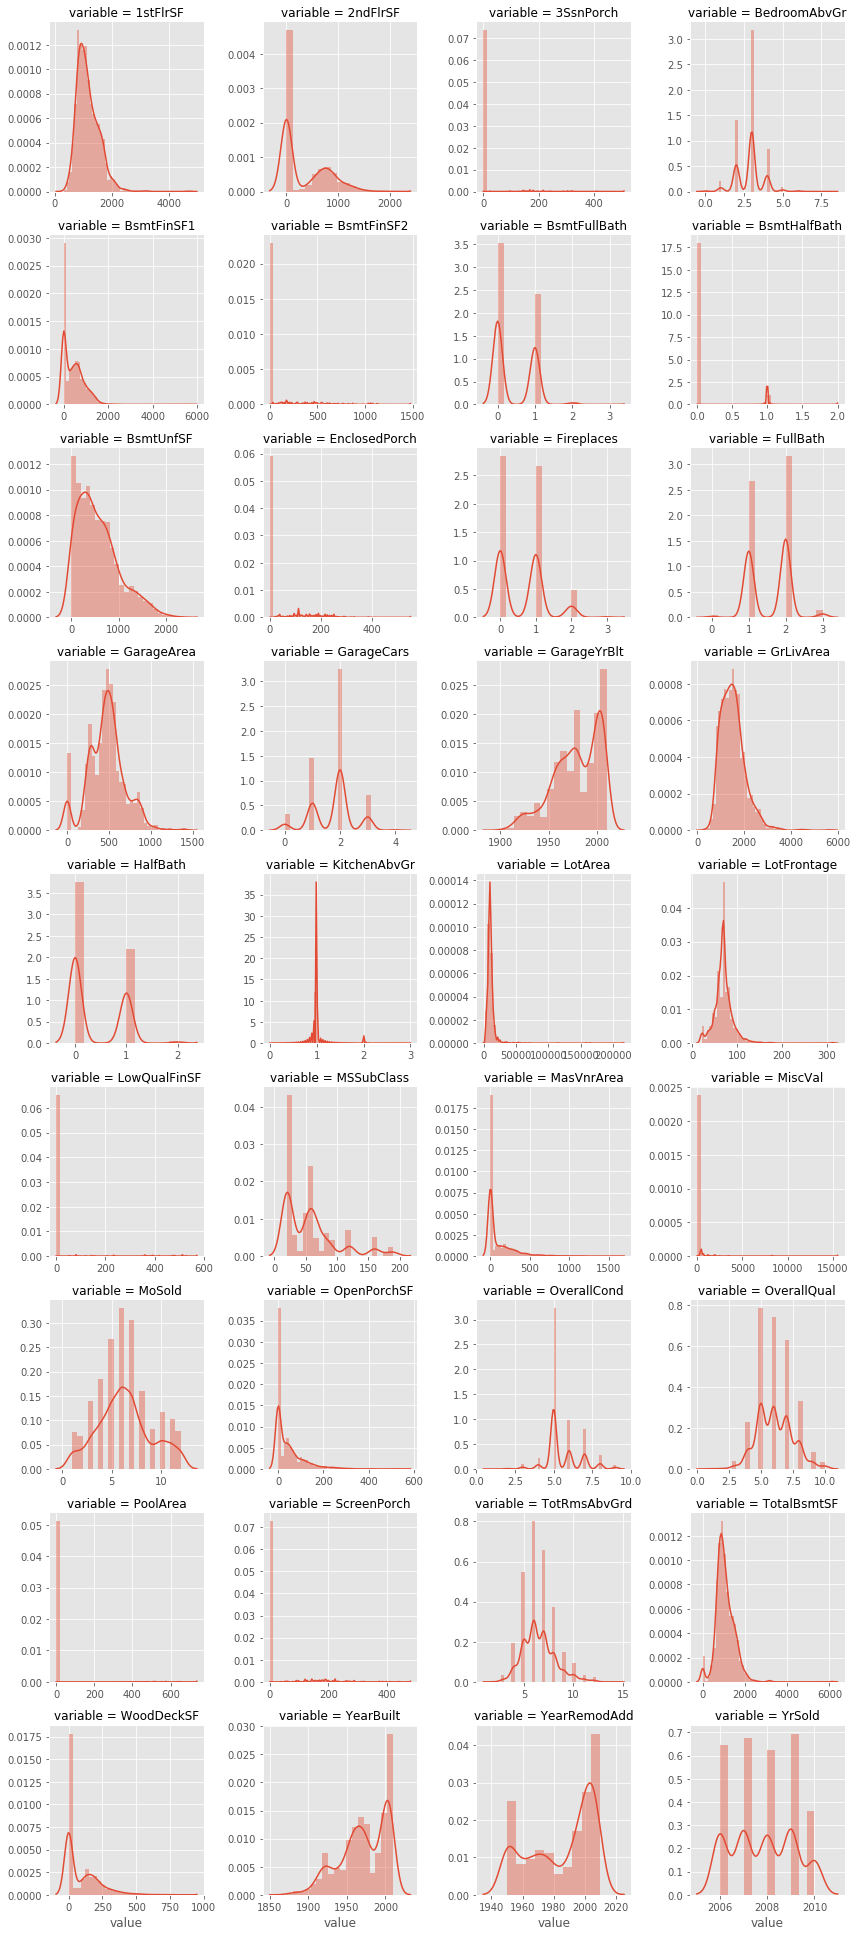

In [13]:
f = pd.melt(train_df,value_vars=numcols)
g = sns.FacetGrid(f, col="variable",col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

* check outliers for numerical columns

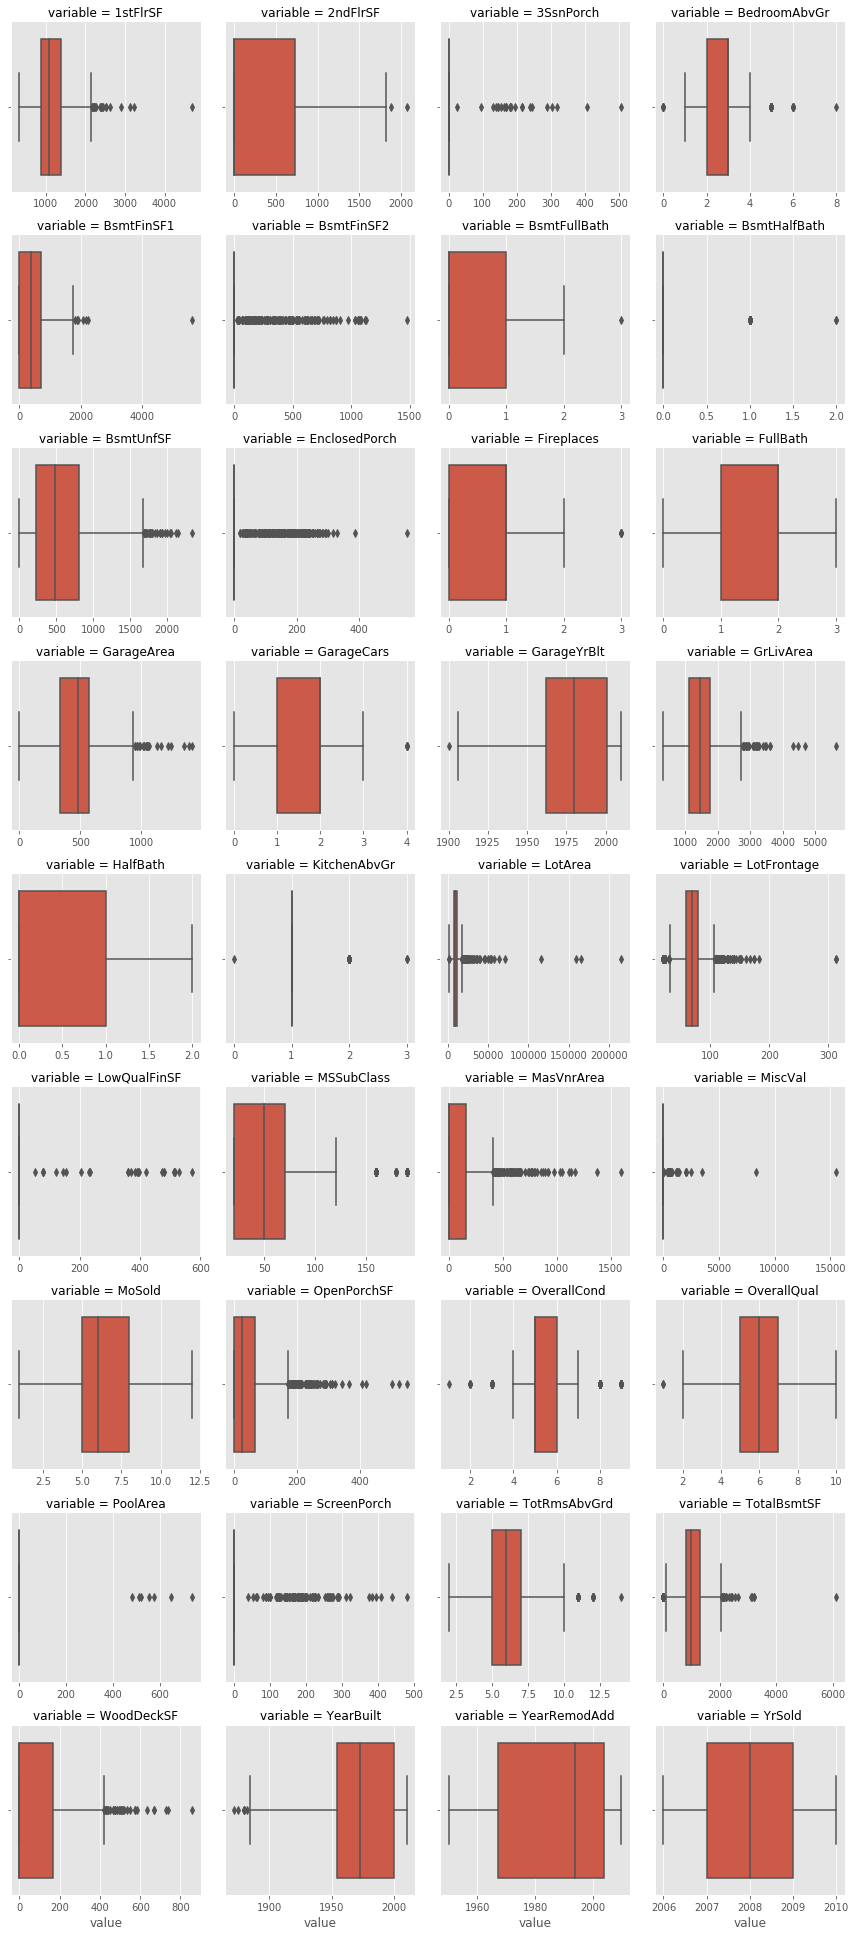

In [14]:
# outliers
f = pd.melt(train_df,value_vars=numcols)
g = sns.FacetGrid(f, col="variable",col_wrap=4, sharex=False, sharey=False)
g = g.map(sns.boxplot, "value")

### Preprocessing 
* take logs for heavy-skewed num cols
* convert cat cols to dummies

In [15]:
train_df = train_df[train_df.GrLivArea<4000]  # GrLivArea is a key feature, taking out outliers is key to improve fitting

In [16]:
bincols = [c for c in numcols if len(train_df[c].unique())>=5]
len(bincols),len(numcols)

(30, 36)

In [17]:
# discretionalize num columns
discretionizer = sklearn.preprocessing.KBinsDiscretizer(n_bins=4, encode='onehot', strategy='quantile')
discretionizer.fit(train_df[bincols])
discols = discretionizer.transform(train_df[bincols])

KBinsDiscretizer(encode='onehot', n_bins=4, strategy='quantile')

In [18]:
discretionizer.n_bins_
colnames = []
for x,y in list(zip(bincols,discretionizer.n_bins_)):
    n = y
    while y>=1:
        colnames.append(x+'_'+str(n-y+1))
        y = y-1
colnames[:5]

array([4, 2, 1, 3, 3, 1, 4, 1, 4, 3, 4, 4, 4, 4, 1, 3, 2, 1, 4, 3, 3, 4,
       1, 1, 4, 4, 2, 4, 4, 4])

['1stFlrSF_1', '1stFlrSF_2', '1stFlrSF_3', '1stFlrSF_4', '2ndFlrSF_1']

In [19]:
discols_df = pd.DataFrame(discols.toarray(),columns=colnames)
discols_df.head()

,1stFlrSF_1,1stFlrSF_2,1stFlrSF_3,1stFlrSF_4,2ndFlrSF_1,2ndFlrSF_2,3SsnPorch_1,BedroomAbvGr_1,BedroomAbvGr_2,BedroomAbvGr_3,...,YearBuilt_3,YearBuilt_4,YearRemodAdd_1,YearRemodAdd_2,YearRemodAdd_3,YearRemodAdd_4,YrSold_1,YrSold_2,YrSold_3,YrSold_4
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [20]:
# log transform to skewed numerical features
skewed_feats = train_df[numcols].apply(lambda x: sp.stats.skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats
# skewed_feats = ['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF1', 'BsmtFinSF2',
#        'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'GrLivArea',
#        'KitchenAbvGr', 'LotArea', 'LotFrontage', 'LowQualFinSF', 'MSSubClass',
#        'MasVnrArea', 'MiscVal', 'OpenPorchSF', 'PoolArea', 'ScreenPorch',
#        'TotalBsmtSF', 'WoodDeckSF']

logtransformer = sklearn.preprocessing.FunctionTransformer(np.log1p,validate=True)
train_df[skewed_feats] = logtransformer.transform(train_df[skewed_feats])

Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath',
       'BsmtUnfSF', 'EnclosedPorch', 'GrLivArea', 'KitchenAbvGr', 'LotArea',
       'LotFrontage', 'LowQualFinSF', 'MSSubClass', 'MasVnrArea', 'MiscVal',
       'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'WoodDeckSF'],
      dtype='object')

In [21]:
# standardize numerical columns
scaler =sklearn.preprocessing.StandardScaler()
scaler.fit(train_df[numcols])
scalecols = scaler.transform(train_df[numcols])
scalecols_df = pd.DataFrame(scalecols,columns=numcols)
scalecols_df.head()

StandardScaler(copy=True, with_mean=True, with_std=True)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,OverallCond,OverallQual,PoolArea,ScreenPorch,TotRmsAbvGrd,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.805990,1.185669,-0.128701,0.165909,0.625446,-0.355892,1.114055,-0.241689,-0.339062,-0.404890,...,-0.517461,0.665646,-0.058688,-0.293206,0.927120,-0.472456,-0.943983,1.053769,0.880629,0.137472
1,0.433256,-0.867410,-0.128701,0.165909,1.257846,-0.355892,-0.819275,4.040898,0.003303,-0.404890,...,2.176545,-0.064709,-0.058688,-0.293206,-0.314155,0.512947,1.253310,0.159469,-0.427190,-0.615009
2,-0.575842,1.189908,-0.128701,0.165909,0.113946,-0.355892,1.114055,-0.241689,0.231214,-0.404890,...,-0.517461,0.665646,-0.058688,-0.293206,-0.314155,-0.317122,-0.943983,0.987524,0.832191,0.137472
3,-0.436663,1.148647,-0.128701,0.165909,-0.513805,-0.355892,1.114055,-0.241689,0.348751,2.840004,...,-0.517461,0.665646,-0.058688,-0.293206,0.306482,-0.715166,-0.943983,-1.860986,-0.717817,-1.367490
4,0.122612,1.249303,-0.128701,1.392121,0.506871,-0.355892,1.114055,-0.241689,0.296484,-0.404890,...,-0.517461,1.396000,-0.058688,-0.293206,1.547757,0.228976,1.084573,0.954402,0.735316,0.137472


In [22]:
# one-hot encoding for categorical variables
ohencoder = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')
ohencoder.fit(train_df[catcols])
ohcols = ohencoder.transform(train_df[catcols])
ohcols_df = pd.DataFrame(ohcols.toarray(),columns=ohencoder.get_feature_names())
ohcols_df.head()

OneHotEncoder(categorical_features=None, categories=None, drop=None,
              dtype=<class 'numpy.float64'>, handle_unknown='ignore',
              n_values=None, sparse=True)

,x0_1Fam,x0_2fmCon,x0_Duplex,x0_Twnhs,x0_TwnhsE,x1_Fa,x1_Gd,x1_Missing,x1_Po,x1_TA,...,x37_ConLD,x37_ConLI,x37_ConLw,x37_New,x37_Oth,x37_WD,x38_Grvl,x38_Pave,x39_AllPub,x39_NoSeWa
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


## feature selection 
* take out features with variance lower than 99%

In [23]:
# combine one hot,numerical, numerical bins 
X_train = pd.concat([scalecols_df,ohcols_df,discols_df],axis=1)
y_train = train_df[targetcol]
X_train.shape

(1456, 378)

In [24]:
import sklearn.feature_selection
selector = sklearn.feature_selection.VarianceThreshold(threshold=0.01)
selector.fit(X_train)
X_train_select = selector.transform(X_train)
X_train_select.shape
X_train_select_cols = [x for x,y in list(zip(X_train.columns,selector.variances_)) if y >=0.01]
X_train_select = pd.DataFrame(X_train_select,columns=X_train_select_cols)
X_train_select.head()

VarianceThreshold(threshold=0.01)

(1456, 288)

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,YearBuilt_3,YearBuilt_4,YearRemodAdd_1,YearRemodAdd_2,YearRemodAdd_3,YearRemodAdd_4,YrSold_1,YrSold_2,YrSold_3,YrSold_4
0,-0.805990,1.185669,-0.128701,0.165909,0.625446,-0.355892,1.114055,-0.241689,-0.339062,-0.404890,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.433256,-0.867410,-0.128701,0.165909,1.257846,-0.355892,-0.819275,4.040898,0.003303,-0.404890,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.575842,1.189908,-0.128701,0.165909,0.113946,-0.355892,1.114055,-0.241689,0.231214,-0.404890,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.436663,1.148647,-0.128701,0.165909,-0.513805,-0.355892,1.114055,-0.241689,0.348751,2.840004,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.122612,1.249303,-0.128701,1.392121,0.506871,-0.355892,1.114055,-0.241689,0.296484,-0.404890,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


## Model fitting

In [25]:
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LassoLarsCV,LinearRegression
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### linear regression

In [26]:
lr = LinearRegression()
lr.fit(X_train_select, y_train)
rmse_cv(lr).mean()

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

609658219.1125131

### Ridge

Text(0.5, 0, 'alpha')

Text(0, 0.5, 'rmse')

0.11189491600432959

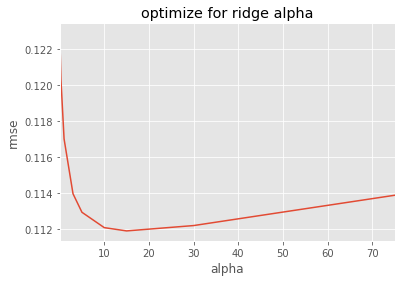

In [27]:
model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "optimize for ridge alpha")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()

In [28]:
alpha_select = cv_ridge.argmin()
model_ridge = Ridge(alpha=alpha_select).fit(X_train_select.values,y_train.values)

### Lasso

In [30]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train_select.values, y_train.values.ravel())
rmse_cv(model_lasso).mean()

0.10937130573485151

In [31]:
coef = pd.Series(model_lasso.coef_, index = X_train_select.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 128 variables and eliminated the other 160 variables


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

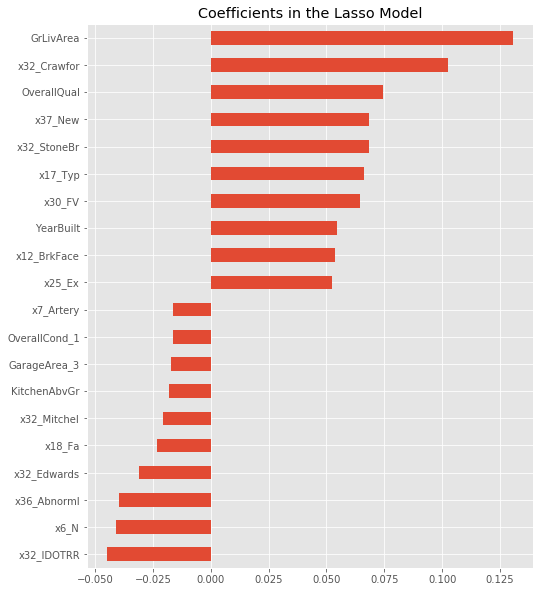

In [32]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

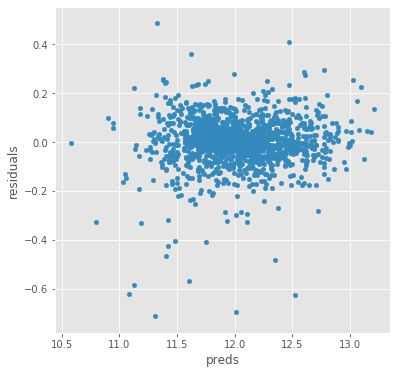

In [33]:
# check residuals
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train_select.values), "true":y_train.values[:,0]})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

### XGBoost

In [34]:
import xgboost as xgb
from xgboost import plot_importance

model = xgb.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=200, silent=False, objective='reg:gamma')
model.fit(X_train_select, y_train)
rmse_cv(model).mean()  # might be overfitting

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:gamma', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)

0.12033330459643758

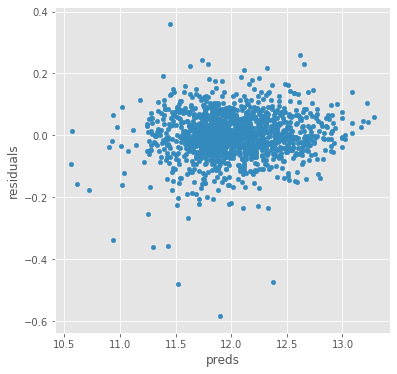

In [35]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":model.predict(X_train_select), "true":y_train.values[:,0]})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

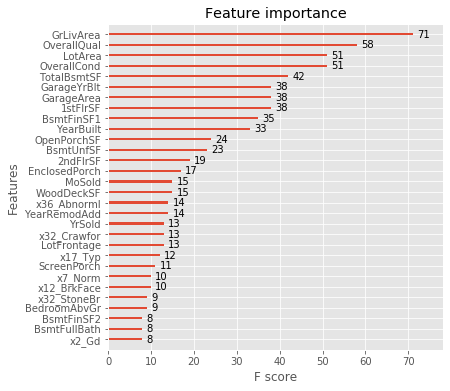

In [36]:
plot_importance(model,max_num_features=30)
plt.show()

### Submission
* we decide to choose lasso 

In [37]:
test_df = pd.read_csv(".\\data\\test.csv")

test_df.drop(delcols,axis=1,inplace=True)
test_df[catcols] = imp_cat.transform(test_df[catcols])
test_df[numcols] = imp_num.transform(test_df[numcols])

In [38]:
test_discols = discretionizer.transform(test_df[bincols])
test_discols_df = pd.DataFrame(test_discols.toarray(),columns=colnames)
test_df[skewed_feats] = logtransformer.transform(test_df[skewed_feats])
test_scalecols = scaler.transform(test_df[numcols])
test_scalecols_df = pd.DataFrame(test_scalecols,columns=numcols)

In [39]:
test_ohcols = ohencoder.transform(test_df[catcols])
test_ohcols_df = pd.DataFrame(test_ohcols.toarray(),columns=ohencoder.get_feature_names())
X_train_select = pd.DataFrame(X_train_select,columns=X_train_select_cols)
X_train_select.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,YearBuilt_3,YearBuilt_4,YearRemodAdd_1,YearRemodAdd_2,YearRemodAdd_3,YearRemodAdd_4,YrSold_1,YrSold_2,YrSold_3,YrSold_4
0,-0.805990,1.185669,-0.128701,0.165909,0.625446,-0.355892,1.114055,-0.241689,-0.339062,-0.404890,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.433256,-0.867410,-0.128701,0.165909,1.257846,-0.355892,-0.819275,4.040898,0.003303,-0.404890,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.575842,1.189908,-0.128701,0.165909,0.113946,-0.355892,1.114055,-0.241689,0.231214,-0.404890,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,-0.436663,1.148647,-0.128701,0.165909,-0.513805,-0.355892,1.114055,-0.241689,0.348751,2.840004,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.122612,1.249303,-0.128701,1.392121,0.506871,-0.355892,1.114055,-0.241689,0.296484,-0.404890,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [40]:
X_test = pd.concat([test_scalecols_df,test_ohcols_df,test_discols_df],axis=1)
X_test.shape

(1459, 378)

In [41]:
X_test_select = selector.transform(X_test)
X_test_select.shape

(1459, 288)

In [42]:
y_pred = model_lasso.predict(X_test_select)

In [43]:
res = pd.DataFrame([test_df['Id'],y_pred]).T
res.columns=['Id','SalePrice']
res.Id = res.Id.apply(lambda x:int(x))
res['SalePrice'] =np.exp(res['SalePrice'])
res.to_csv(".\\data\\submission.csv",index=False)

## summary
* final score on Kaggle: 0.1181, ranked 907